In [6]:
import os
import sys
sys.path.insert(1, '../mdai/')

import shutil
from random import randint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import VGG
from torch.autograd import Variable
from torchsummary import summary
import segmentation_models_pytorch as smp

from PIL import Image
import cv2
import albumentations as alb # A

import time
import os
from tqdm.notebook import tqdm
from workspace import paths_get, paths_join
from mdai_odd_data_wrangling import OpticDiscDrusenDataset

import warnings
warnings.filterwarnings('ignore')

## Sort out the paths required

In [7]:
DATA  = 'mdai-odd'
IMAGE = 'image'
MASK  = 'mask'

base_dir, data_dir, _, _, _ = paths_get('oct2l')
data_dir = paths_join(data_dir, DATA)

''' for my own use:
os.chdir(data_dir)
os.rename('images_with_masks_mdai', IMAGE)
os.rename('mdai_labelled_data', MASK)
os.chdir(base_dir)
'''

# for me only.

" for my own use:\nos.chdir(data_dir)\nos.rename('images_with_masks_mdai', IMAGE)\nos.rename('mdai_labelled_data', MASK)\nos.chdir(base_dir)\n"

import id_map to link images and masks later

In [8]:
id_map = pd.read_csv(paths_join(data_dir, 'id_map.csv'))
id_map = id_map[['id', 'Slice_ODD_id', 'labelName']]

display(id_map.head())
print('Total images: ', id_map.id.nunique())

for label_name in id_map['labelName'].unique():
    print('Number of %s: %d' % (
        label_name, id_map[id_map['labelName']==label_name]['id'].nunique()))

,id,Slice_ODD_id,labelName
0,A_Km5eJK,56_ODD-245_OS,Drusen
1,A_K0a9yV,56_ODD-245_OS,Drusen
2,A_VovNDK,56_ODD-245_OS,Drusen
3,A_gjq2PL,40_ODD-245_OS,Drusen
4,A_KAkM1L,37_ODD-245_OS,Drusen


Total images:  1754
Number of Drusen: 509
Number of Blood vessel: 398
Number of Hyperreflective Line: 847


In [9]:
IMAGE_PATH = paths_join(data_dir, IMAGE)
MASK_PATH = paths_join(data_dir, MASK)

print('IMAGE_PATH: %s' % IMAGE_PATH)
print('MASK_PATH: %s' % MASK_PATH)

n_classes = 3

x_trainval, x_test = train_test_split(id_map['id'].values, test_size=0.2, random_state=42)
x_train, x_val = train_test_split(x_trainval, test_size=0.25, random_state=42)
print('\n')
print('x_train  : %.1f' % (len(x_train)/id_map.id.nunique()))
print('x_test   : %.1f' % (len(x_test)/id_map.id.nunique()))
print('x_val    : %.1f' % (len(x_val)/id_map.id.nunique()))

IMAGE_PATH: /Users/miaomiaoyu/workspace/oct2l/data/mdai-odd/image
MASK_PATH: /Users/miaomiaoyu/workspace/oct2l/data/mdai-odd/mask


x_train  : 0.6
x_test   : 0.2
x_val    : 0.2


Show an example of image and mask overlaid

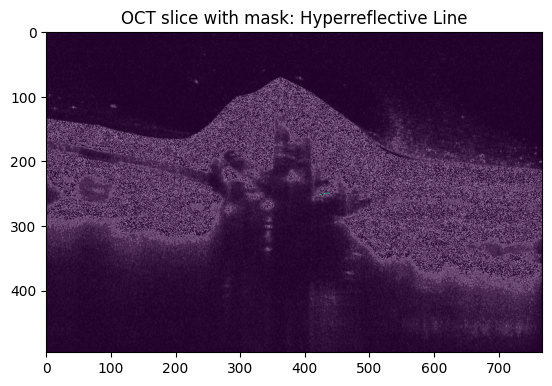

In [10]:
idx = randint(0, id_map.id.nunique())   # randomly choose an index

img = Image.open(paths_join(IMAGE_PATH, [id_map.loc[idx,'id']+'.png']))
img = np.asarray(img)
mask = np.load(paths_join(MASK_PATH, [id_map.loc[idx,'id']+'.npy']))

plt.imshow(img**2, cmap='binary')
plt.imshow(mask, alpha=.5)
plt.title('OCT slice with mask: %s' % id_map.loc[idx,'labelName'])
plt.show()

Note! <br></br>
VGG16 and AlexNet both require inputs with 3_channels (trained that way). <br>
It seems like the thing to do is just repeat the greyscale image 3 times along the 3rd dimension, so ok. 

In [11]:
# Keeping this simple - just make them into tensors.

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256,256))
    ])  # ToTensor first!

train_set = OpticDiscDrusenDataset(
    IMAGE_PATH, MASK_PATH, x_train, transform=preprocess, target_transform=preprocess)

val_set = OpticDiscDrusenDataset(
    IMAGE_PATH, MASK_PATH, x_val, transform=preprocess, target_transform=preprocess)

batch_size = 64

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

feature batch shape: torch.Size([64, 3, 256, 256])
labels batch shape: torch.Size([64, 1, 256, 256])
 -> [batch_size, n_channels, img_height, img_width]


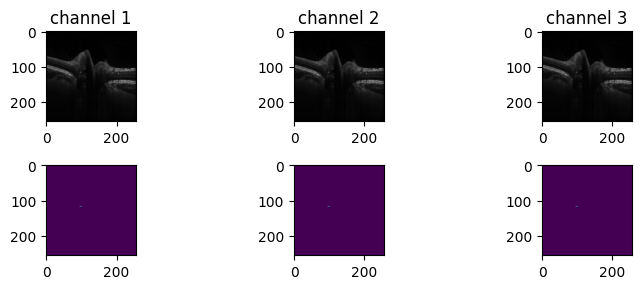

In [13]:
# Quick check to make sure you're on the same page

train_features, train_labels = next(iter(train_loader))
print(f"feature batch shape: {train_features.size()}")
print(f"labels batch shape: {train_labels.size()}")
print(f" -> [batch_size, n_channels, img_height, img_width]")
n_channels = train_features.size()[1]

idx = randint(0, batch_size) 

f, ax = plt.subplots(2, n_channels, figsize=(8,3))
for i in range(n_channels):
    img = train_features[idx,i,:,:].squeeze()
    label = train_labels[idx].squeeze()
    ax[0,i].imshow(img, cmap='binary_r')
    ax[1,i].imshow(label)
    ax[0,i].set_title('channel %d' % (i+1))
plt.tight_layout()
plt.show()

# Model

In [4]:
'''model = smp.Unet(
    encoder_name='vgg16', 
    encoder_depth=5, 
    classes=3,
    encoder_weights='imagenet')'''

# obtain a pretrained model
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)
model.eval()

Using cache found in /Users/miaomiaoyu/.cache/torch/hub/pytorch_vision_v0.10.0


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [14]:
input_batch = train_features

import torchvision.models as models

# Hyper parameters
num_epochs = 5
num_classes = 3
batch_size = 100
learning_rate = 0.001

model = models.vgg16(pretrained=True)
model.classifier[6].out_features = n_classes  
# This changes attribute 'out_features' for torch.nn.Linear, but not the wieghts that carry out the computation
model.classifier[6] = torch.nn.Linear(4096, n_classes)

'''model = VGG(
    'vgg16', num_classes=10, init_weights=True)
model.eval()'''

output = model(input_batch)

In [31]:
output.size()
probabilities = torch.nn.functional.softmax(output[0], dim=0)
probabilities

tensor([0.0940, 0.0986, 0.1108, 0.1082, 0.0807, 0.1160, 0.1103, 0.1224, 0.0851,
        0.0739], grad_fn=<SoftmaxBackward0>)

In [35]:
# https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/convolutional_neural_network/main.py

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

RuntimeError: 0D or 1D target tensor expected, multi-target not supported

In [40]:
images.shape, labels.shape

# here I realised that VGG seems to want to attach one label per image, but i want them to attach one label per pixel. 

(torch.Size([64, 3, 256, 256]), torch.Size([64, 1, 256, 256]))

In [16]:

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')
with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities)

TypeError: 'str' object is not callable

In [17]:
output[0]

NameError: name 'output' is not defined

#### what does unfold do?

torch.Size([512, 768])
torch.Size([512, 3, 256])


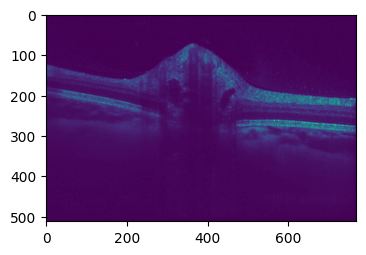

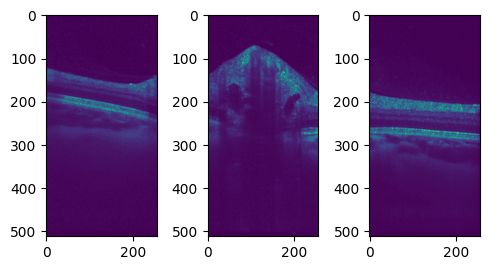

In [ ]:
print(img.shape)
print(img.unfold(1,256,256).shape)
# Extracts sliding local blocks from a batched input tensor.

plt.figure(figsize=(4,3))
plt.imshow(img)
plt.show()

f, ax = plt.subplots(1,3, figsize=(5,3))
ax[0].imshow(img.unfold(1,256,256)[:,0,:])
ax[1].imshow(img.unfold(1,256,256)[:,1,:])
ax[2].imshow(img.unfold(1,256,256)[:,2,:])
plt.tight_layout()
plt.show()